In [1]:
# Import modules
import pandas as pd
import numpy as np
from numpy.random import random
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from ipywidgets import interact,widgets

# Clustering

In [2]:
# Create an artificial dataset of 100 samples, 2 features and 3 centers with a specific standard deviation
# The targets are the center the samples are assigned to. In real situations we would not know this!
features,targets = make_blobs(n_samples=100,n_features=2,centers=3,cluster_std=0.8,random_state=0)

In [3]:
# Create a dataframe of our features
df = pd.DataFrame(features,columns=['f1','f2'],)
df.head()

,f1,f2
0,2.516540,0.731025
1,0.259897,4.613309
2,2.813069,0.773656
3,-0.314848,4.133595
4,0.137428,3.167773


/home/cedric/miniforge3/envs/bit07/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='f1', ylabel='f2'>

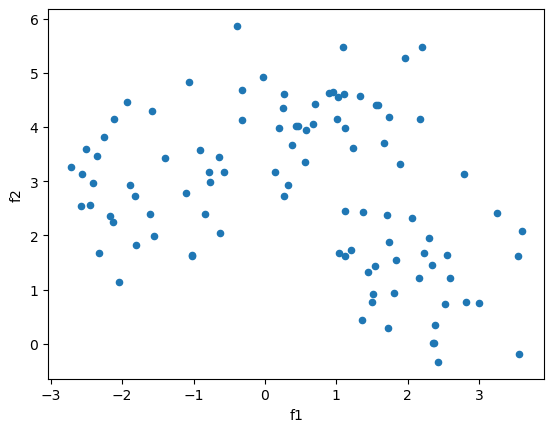

In [4]:
# Plot the 2 features
df.plot(x="f1",y="f2",kind="scatter",cmap="viridis")

## K-means clustering
In K-means clustering we will try to divide our data into K distinct sets (clusters).

### Step 1

The first step is to initialize the algorithm by choosing K initial cluster centroid locations. This is typically done by randomly choosing K points from the input set.

In [5]:
K = 3
# pd.Dataframe.sample returns x number of random samples from the dataset
# Info: sample has a parameter "replace", that when set as True, will allow the same sample to be picked multiple times.
# By default this is False. So we don't have to worry about that.
# "random_state" will allow you to reproduce the same samples each time 
centroids = df.sample(K,random_state=0).values

# Set seed so we can always reproduce the same colors
np.random.seed(0)
# Generate K colors in format (red,green,blue) -> values between 0 and 1
colors    = np.array([(random(),random(),random()) for _ in range(K)])

In [6]:
print("Centroids:",centroids)
print("Colors:",colors)

Centroids: [[1.43933466 1.32906301]
 [0.9537243  4.64645282]
 [2.8130691  0.77365559]]
Colors: [[0.5488135  0.71518937 0.60276338]
 [0.54488318 0.4236548  0.64589411]
 [0.43758721 0.891773   0.96366276]]


In [7]:
def plot_figure(data,centr,col,cti=None):
    """
    Function plot_figure() creates a matplotlib figure based on a datafram 'data'
    a list of centroids 'cent' and uses different colors 'col'. cti is a list of
    the indexes of the closest centroid for each point. If not provided, it will
    just plot blue dots instead of coloring them.
    """
    fig = plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.axis('equal')
    if cti:
        colors_to_show = [col[ind] for ind in cti]
        data.plot(x="f1",y="f2",kind="scatter",color=colors_to_show,ax=ax)
    else:
        data.plot(x="f1",y="f2",kind="scatter",ax=ax)
    for centroid,color in zip(centr,col):
        plt.scatter(x=centroid[0],y=centroid[1],color=color,s=150,marker="*",edgecolors="black")

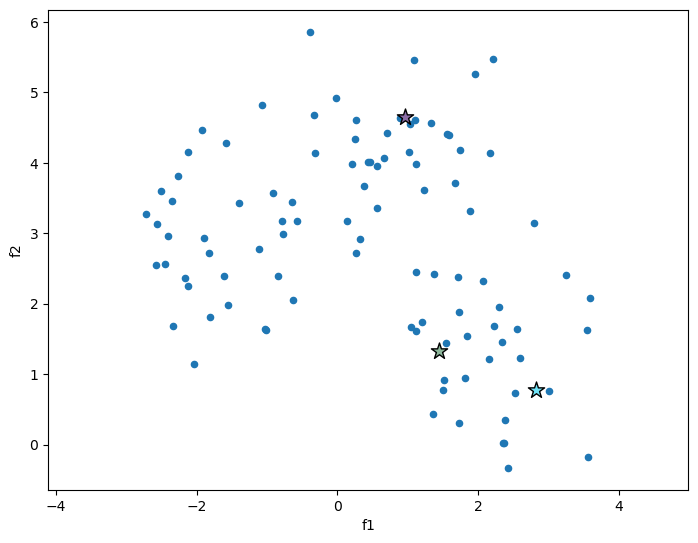

In [8]:
## Plot the centroids in between the points as stars

plot_figure(data=df,centr=centroids,col=colors)

### Step 2
Cluster Assignment - Here, each observation (e.g., each point in the data set) is assigned to a cluster centroid based on the centroid that is closest to the point

In [9]:
from math import sqrt

def distance(p1,p2):
    """
    Function distance() calculates the distance between 2 points 'p1' and 'p2'
    where a point is a list with 2 values x and y ([x,y])
        
    |\
    | \
   b|  \c
    |   \
    |____\
      a
      
    => pythagoras: a² + b² = c² 
    """
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_closest_centroid(features,centroids):
    """
    Function get_closest_centroid() takes in a list 'features' and a list 'centroids'.
    For each point, the index of the closest centroid will be determined.
    The function returns a list of indexes of centroids in the same order as the list
    of features.
    """
    # Initialize an empty list to add the index of the closest centroid to
    closest_centroid_index = []
    # For every point/sample in our dataset
    for point in features:
        min_dist=9999                               # Just a large starting distance
        index=-1                                    # Initialize an index
        # for the index of the centroid and the centroid itself
        for ind,centroid in enumerate(centroids):
            # Calculate each distance
            dist=distance(point,centroid)
            # If our new distance is smaller than our current minimum, we found a new minimum!
            if dist<min_dist:
                min_dist=dist
                index=ind
        # Add the index of the closest centroid to the list
        closest_centroid_index.append(index)
    return closest_centroid_index

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_29330/3869565230.py:4: SyntaxWarning: invalid escape sequence '\c'
  """


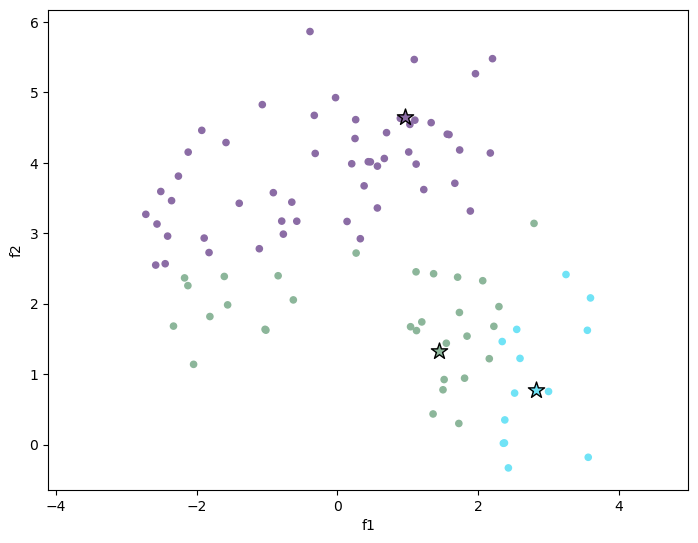

In [10]:
# Get a list of indexes of the closest centroid per feature
closest_centroid_list = get_closest_centroid(features,centroids)

# Plot the points with the color being the color of the closest centroid
plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)


#### Informational note
The visualisations of the areas that are closest to a specific point is also called a "voronoi" diagram

Example voronoi diagram:
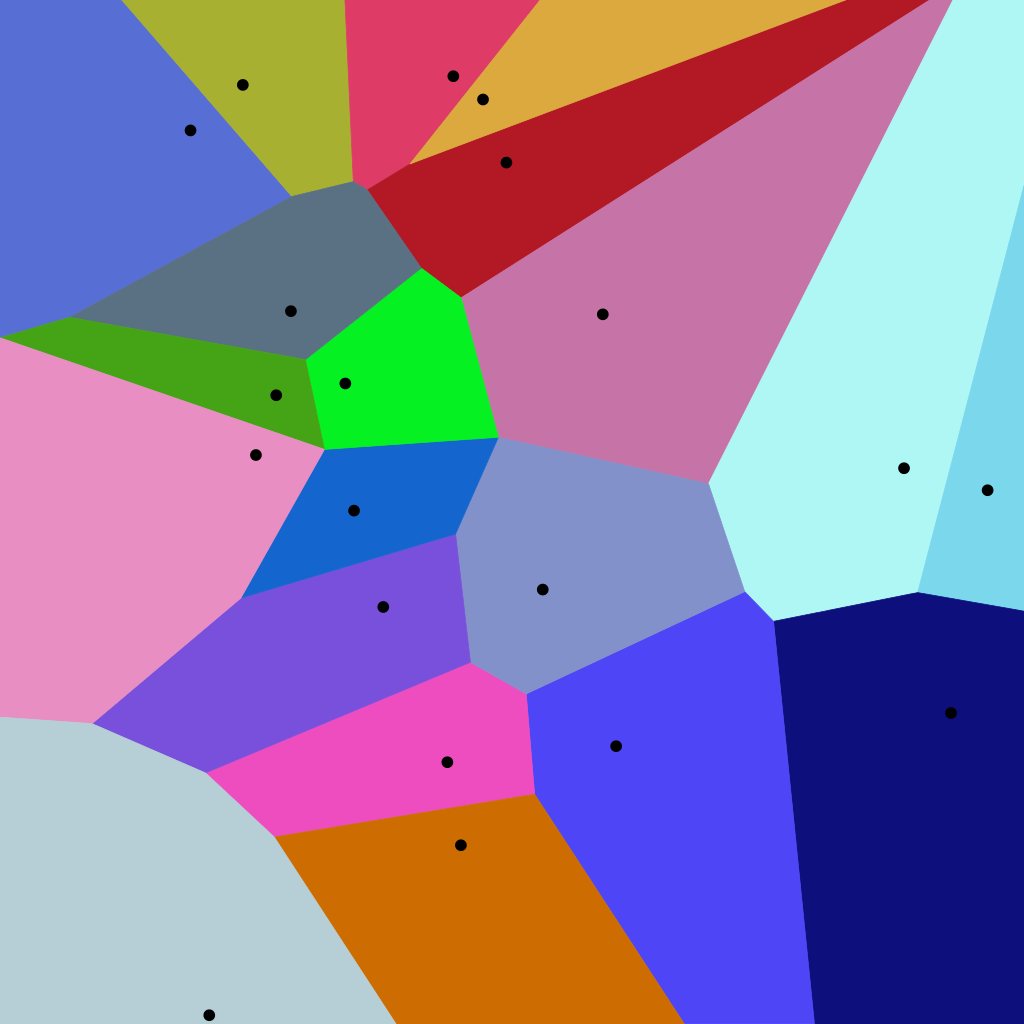

### Step 3
Update the centroid locations based on the mean distance of the closest points to that centroid

In [11]:
# Calculate the center of all points closest to a centroid
# Update the centroids to these newly calculated centers

def calculate_new_centroids(features,closest_centroid_list):
    """
    Function calculate_new_centroids takes in a list 'features' and a list 'closest_centroid_list'
    and returns a list of new centroids based on the average (mean) of the points per centroid
    """
    return [np.average([features[n] for n,i in enumerate(closest_centroid_list) if i == x],axis=0) \
                 for x in set(closest_centroid_list)]
    """
    For each centroid (set(closest_centroid_list)) a list is constructed of only the samples that belong to
    that specific centroid. Next we just calculate the average of each each feature (axis=0)
    """
    

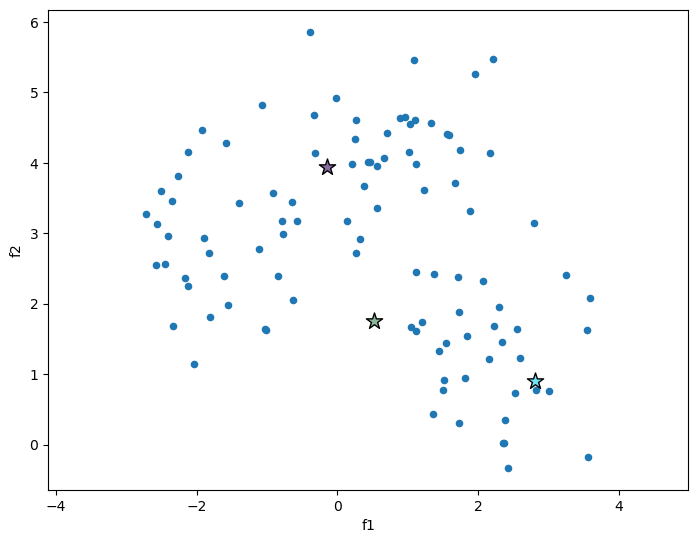

In [12]:
# Update the centroids
centroids = calculate_new_centroids(features,closest_centroid_list)

# Plot the newly calculated centroids
plot_figure(df,centroids,colors)

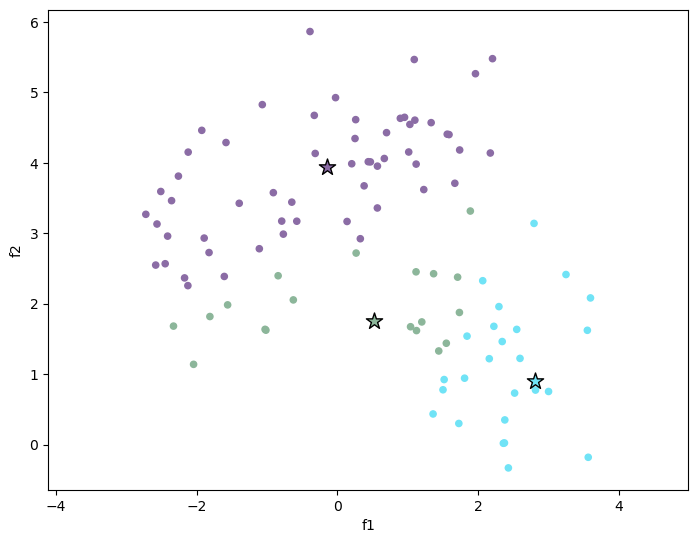

In [13]:
# Determine the closest points again

# Get a list of indexes of the closest centroid per feature
closest_centroid_list = get_closest_centroid(features,centroids)

# Plot the points with the color being the color of the closest centroid
plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)

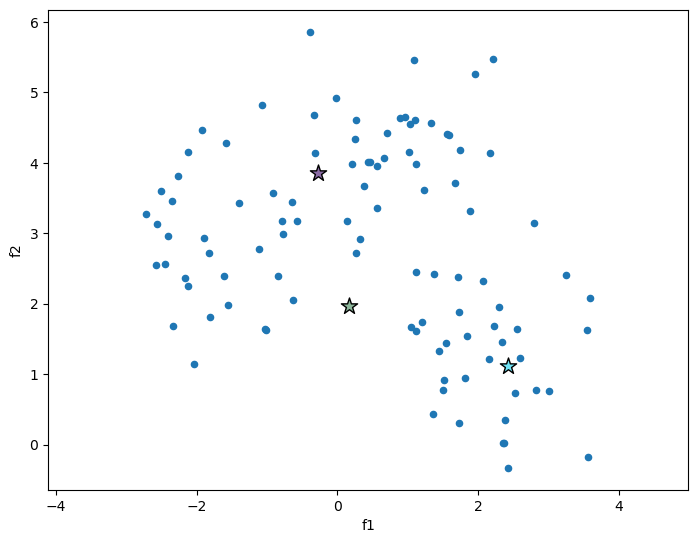

In [14]:
# Update the centroids
centroids = calculate_new_centroids(features,closest_centroid_list)

# Plot the newly calculated centroids
plot_figure(df,centroids,colors)

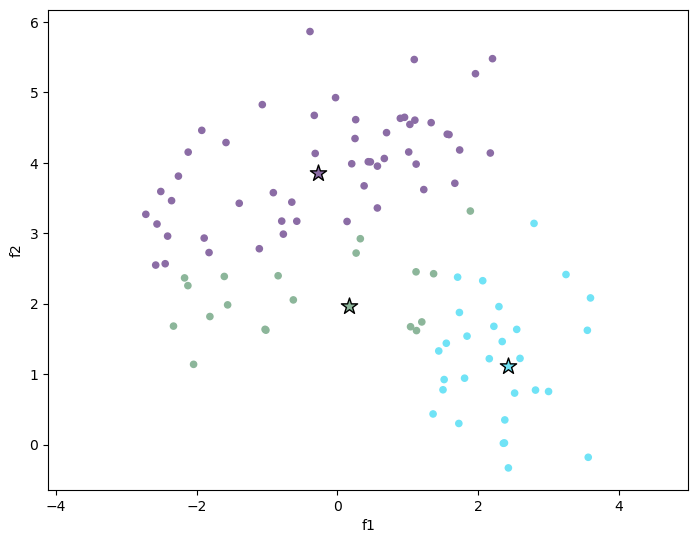

In [15]:
# Determine the closest points again

# Get a list of indexes of the closest centroid per feature
closest_centroid_list = get_closest_centroid(features,centroids)

# Plot the points with the color being the color of the closest centroid
plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)

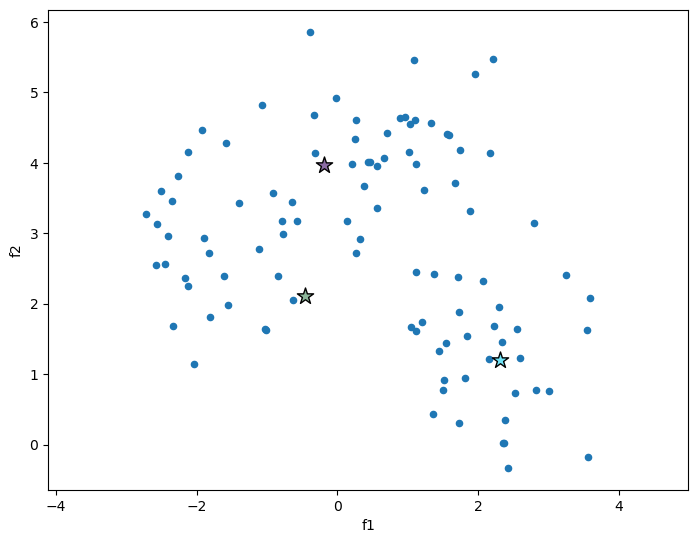

In [16]:
# Update the centroids
centroids = calculate_new_centroids(features,closest_centroid_list)

# Plot the newly calculated centroids
plot_figure(df,centroids,colors)

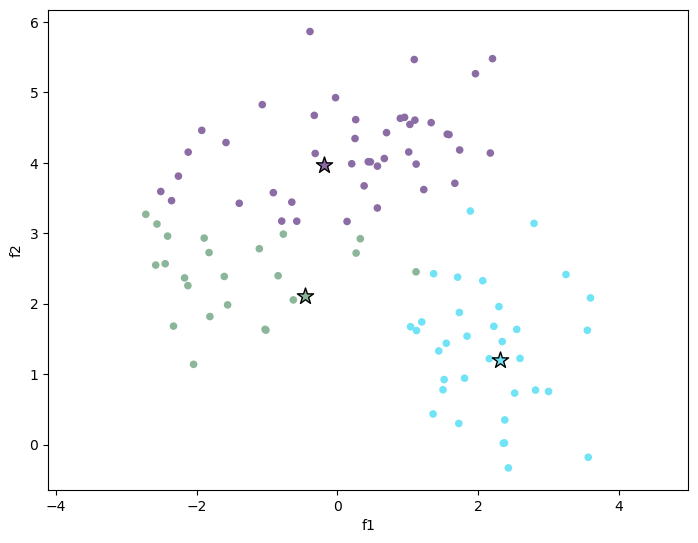

In [17]:
# Determine the closest points again

# Get a list of indexes of the closest centroid per feature
closest_centroid_list = get_closest_centroid(features,centroids)

# Plot the points with the color being the color of the closest centroid
plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)

## All in one - interactive

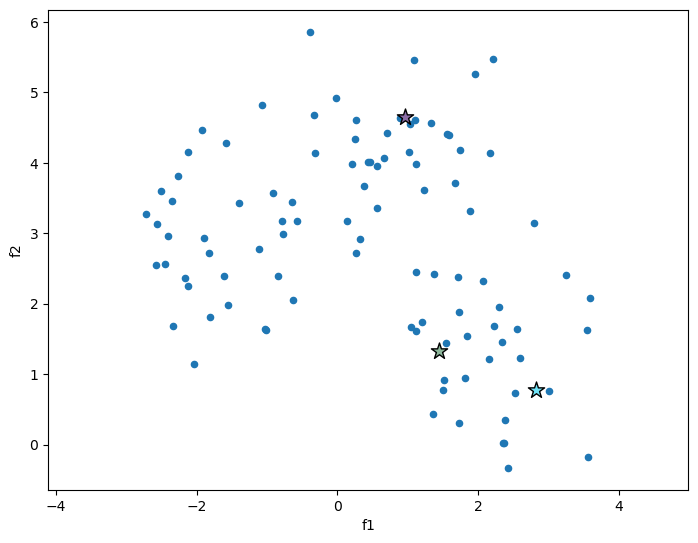

In [18]:
from IPython.display import clear_output
# Create a previous and next button
pre = widgets.Button(
    description='Previous step',
    icon='arrow-left',
)
nex = widgets.Button(
    description='Next step',
    icon='arrow-right'
)
default_clusters=3
no_clusters = widgets.BoundedIntText(min=1,max=10,value=default_clusters,description="clusters", continuous_update=False)

# Show the interactive widgets (on one line)
display(widgets.HBox([pre,nex,no_clusters]))

############################################################################################
#                                   Initial values                                         #
############################################################################################

# Start at step = 0
step=0
show_wcss=True

# Load in data
features,targets = make_blobs(n_samples=100,n_features=2,centers=3,cluster_std=0.8,random_state=0)
df = pd.DataFrame(features,columns=['f1','f2'],)

# Initialize clusters and also assign a random color for each
centroids = df.sample(default_clusters,random_state=0).values
np.random.seed(0)
colors    = [(random(),random(),random()) for _ in range(default_clusters)]



############################################################################################
#                                   Functions                                              #
############################################################################################

def run(button=None):
    clear_output()
    
    global step
    if button:
        if button.description=='Previous step' and step>0:
            step-=1
        elif button.description=='Next step':
            step+=1
    if step==0:
        pre.disabled=True
    else:
        pre.disabled=False
    display(widgets.HBox([pre,nex,no_clusters]))
    centroids_new=[]
    for i in range(step):
        if i%2:
            centroids_new = calculate_new_centroids(features,closest_centroid_list)
        else:
            if len(centroids_new)!=0:
                closest_centroid_list = get_closest_centroid(features,centroids_new)
            else:
                closest_centroid_list = get_closest_centroid(features,centroids)
    if len(centroids_new)!=0:
        if step%2:
            print("Determine closest centroid per point")
            if show_wcss:
                print(f"WCSS: {wcss(features,centroids_new)}")
            plot_figure(data=df,centr=centroids_new,col=colors,cti=closest_centroid_list)
        else:
            print("Update centroids")
            plot_figure(data=df,centr=centroids_new,col=colors)
        
    else:
        if step%2:
            print("Determine closest centroid per point")
            if show_wcss:
                print(f"WCSS: {wcss(features,centroids)}")
            plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)
        else:
            plot_figure(data=df,centr=centroids,col=colors)

## General form of the function
def calculate_new_centroids(features,closest_centroid_list):
    """
    Function calculate_new_centroids takes in a list 'features' and a list 'closest_centroid_list'
    and returns a list of new centroids based on the average (mean) of the points per centroid
    """
    return [np.average([features[n] for n,i in enumerate(closest_centroid_list) if i == x],axis=0) \
                 for x in (set(closest_centroid_list))]
    
def updateClusters(input_box):
    global centroids,colors
    centroids = df.sample(input_box.new,random_state=0).values
    np.random.seed(0)
    colors    = [(random(),random(),random()) for _ in range(input_box.new)]
    run()
    
from math import sqrt
def distance(p1,p2):
    """
    Function distance() calculates the distance between 2 points 'p1' and 'p2'
    where a point is a list with 2 values x and y ([x,y])
    
    |\
    | \
   b|  \c
    |   \
    |____\
      a
      
    => pythagoras: a² + b² = c² 
    """
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def wcss(features,centroids):
    """
    Function wcss() takes in a list 'features' and a list 'centroids' and returns the within cluster sum of squares.
    """
    wcss_total=0
    for point in features:
        min_dist=9999 # Just a large starting distance
        for ind,centroid in enumerate(centroids):
            min_dist=min(dist:=distance(point,centroid),min_dist)
        wcss_total+=min_dist**2
    return wcss_total
        

def get_closest_centroid(features,centroids):
    """
    Function get_closest_centroid() takes in a list 'features' and a list 'centroids'.
    For each point, the index of the closest centroid will be determined.
    The function returns a list of indexes of centroids in the same order as the list
    of features.
    """
    closest_centroid_index = []
    for point in features:
        min_dist=9999 # Just a large starting distance
        index=-1
        for ind,centroid in enumerate(centroids):
            dist=distance(point,centroid)
            if dist<min_dist:
                min_dist=dist
                index=ind
        closest_centroid_index.append(index)
    return closest_centroid_index

def plot_figure(data,centr,col,cti=None):
    """
    Function plot_figure() creates a matplotlib figure based on a datafram 'data'
    a list of centroids 'cent' and uses different colors 'col'. cti is a list of
    the indexes of the closest centroid for each point. If not provided, it will
    just plot blue dots instead of coloring them.
    """
    fig = plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.axis('equal')
    if cti:
        colors_to_show = [col[ind] for ind in cti]
        data.plot(x="f1",y="f2",kind="scatter",color=colors_to_show,ax=ax)
    else:
        data.plot(x="f1",y="f2",kind="scatter",ax=ax)
    for centroid,color in zip(centr,col):
        plt.scatter(x=centroid[0],y=centroid[1],color=color,s=150,marker="*",edgecolors="black")


############################################################################################
#                                   Run the interactive code                               #
############################################################################################       
# Initialize the first time
run()        

# Bind buttons to run function
pre.on_click(run)
nex.on_click(run)
# Bind numeric input to updateClusters function
no_clusters.observe(updateClusters, names=['value'])

## More than two dimensions
No problem, you can calculate distances in more than 2 dimensions. Even in dimensions we can't display (>3 dimensions)

Below you find a similar implementation as before, but now in 3 dimensions

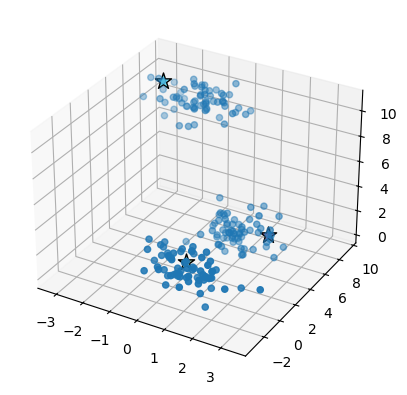

In [19]:
from IPython.display import clear_output
# Create a previous and next button
pre = widgets.Button(
    description='Previous step',
    icon='arrow-left'
)
nex = widgets.Button(
    description='Next step',
    icon='arrow-right'
)
default_clusters=3
no_clusters = widgets.BoundedIntText(min=1,max=10,value=default_clusters,description="clusters", continuous_update=False)

############################################################################################
#                                   Initial values                                         #
############################################################################################

step=0
features,targets = make_blobs(n_samples=200,n_features=3,centers=3,cluster_std=0.8,random_state=0)
df = pd.DataFrame(features,columns=['f1','f2','f3'])

centroids = df.sample(default_clusters,random_state=0).values
np.random.seed(0)
colors    = [(random(),random(),random()) for _ in range(default_clusters)]

############################################################################################
#                                   Functions                                              #
############################################################################################

def run(button=None):
    clear_output()
    display(widgets.HBox([pre,nex,no_clusters],))
    global step
    if button:
        if button.description=='Previous step' and step>0:
            step-=1
        elif button.description=='Next step':
            step+=1
    centroids_new=[]
    for i in range(step):
        if i%2:
            centroids_new = calculate_new_centroids(features,closest_centroid_list)
        else:
            if len(centroids_new)!=0:
                closest_centroid_list = get_closest_centroid(features,centroids_new)
            else:
                closest_centroid_list = get_closest_centroid(features,centroids)
    if len(centroids_new)!=0:
        if step%2:
            plot_figure(data=df,centr=centroids_new,col=colors,cti=closest_centroid_list)
        else:
            plot_figure(data=df,centr=centroids_new,col=colors)
        
    else:
        if step%2:
            plot_figure(data=df,centr=centroids,col=colors,cti=closest_centroid_list)
        else:
            plot_figure(data=df,centr=centroids,col=colors)

## General form of the function
def calculate_new_centroids(features,closest_centroid_list):
    """
    Function calculate_new_centroids takes in a list 'features' and a list 'closest_centroid_list'
    and returns a list of new centroids based on the average (mean) of the points per centroid
    """
    return [np.average([features[n] for n,i in enumerate(closest_centroid_list) if i == x],axis=0) \
                 for x in (set(closest_centroid_list))]
    
def updateClusters(input_box):
    global centroids,colors
    centroids = df.sample(input_box.new,random_state=0).values
    np.random.seed(0)
    colors    = [(random(),random(),random()) for _ in range(input_box.new)]
    run()
    
from math import sqrt
def distance(p1,p2):
    """
    Function distance() calculates the distance between 2 points 'p1' and 'p2'
    where a point is a list with 2 values x and y ([x,y])
    """
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def get_closest_centroid(features,centroids):
    """
    Function get_closest_centroid() takes in a list 'features' and a list 'centroids'.
    For each point, the index of the closest centroid will be determined.
    The function returns a list of indexes of centroids in the same order as the list
    of features.
    """
    closest_centroid_index = []
    for point in features:
        min_dist=9999 # Just a large starting distance
        index=-1
        for ind,centroid in enumerate(centroids):
            dist=distance(point,centroid)
            if dist<min_dist:
                min_dist=dist
                index=ind
        closest_centroid_index.append(index)
    return closest_centroid_index

def plot_figure(data,centr,col,cti=None):
    """
    Function plot_figure() creates a matplotlib figure based on a datafram 'data'
    a list of centroids 'cent' and uses different colors 'col'. cti is a list of
    the indexes of the closest centroid for each point. If not provided, it will
    just plot blue dots instead of coloring them.
    """
    fig = plt.figure()
    ax=fig.add_subplot(projection='3d')
    #ax.axis('equal')
    if cti:
        print("Determine closest centroid per point")
        colors_to_show = [col[ind] for ind in cti]
        ax.scatter(data.f1,data.f2,data.f3,color=colors_to_show)
    else:
        if step!=0:
            print("Update centroid location")
        ax.scatter(data.f1,data.f2,data.f3)
    for centroid,color in zip(centr,col):
        ax.scatter(centroid[0],centroid[1],centroid[2],color=color,s=150,marker="*",edgecolors="black")


############################################################################################
#                                   Run the interactive code                               #
############################################################################################       
# Initialize the first time
run()        

# Bind buttons to run function
pre.on_click(run)
nex.on_click(run)
# Bind numeric input to updateClusters function
no_clusters.observe(updateClusters, names=['value'])

## Optimal number of clusters
How can we determine the optimal number of clusters?

### Visual inspection of the data
Plot the datapoints and take a look at what might be a logical number of clusters

### Silhouette clustering
Compares the intra-cluster distance with the inter-cluster distance.
- Intra-cluster distance (a): the average distance between all points in a single cluster
- Inter-cluster distance (b): the average distance between the clusters

$Silhouette score = \Large\frac{b-a}{max(a,b)}$

This will not be discussed


### Elbow method
For the elbow method, we will calculate the total within-cluster sum of square (wcss)

$WCSS = \Large\sum_{C_k}^{C_n}(\sum_{d_i in C_i}^{d_m}distance(d_i,C_k)^2)$

Or in words: calculate the distance of each point to its corresponding centroid, square it and take the sum of all of them.

Do this for K number of clusters and plot the sum of these distance in a graph versus the number of clusters.

This will result in a graph like:
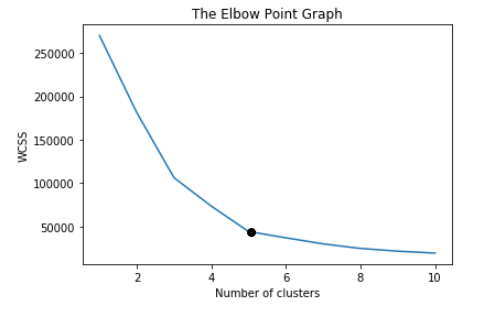

We define the best number of clusters as the point were a drop in distance does not decrease greatly anymore. In the example above, this would be at 5 clusters.

The 2D all in one interactive version of K-means clustering contains a function wcss, if you're interested in this calculation. By default it is not calculated, just change `show_wcss=False` to `show_wcss=True`. Every time the closest points are calculated, the wcss will be displayed as well.

Take a look at the effect of a different number of clusters on the wcss. Set the step at for example 10 to already start after 5 updates of points.

Jump to code: [click here](#All-in-one---interactive)

We will plot the elbow method in the sklearn implementation

## Sklearn implementation

In [20]:
from sklearn.cluster import KMeans

# Initialize the model
model = KMeans(n_clusters=4)

# Create features and targets (targets just as reference, in clustering we don't need any targets)
features, targets = make_blobs(n_samples=100,
                               n_features=2,
                               centers=4,
                               cluster_std=0.8,
                               random_state=0)
df = pd.DataFrame(
    features,
    columns=['f1', 'f2'],
)

# Fit the model
model.fit(features)

# Predict the clusters for each sample
pred_cluster = model.predict(features)

In [21]:
pred_cluster

array([2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 2, 1, 3, 2, 0,
       1, 3, 2, 1, 2, 2, 3, 3, 3, 0, 3, 3, 1, 2, 0, 3, 0, 1, 2, 1, 0, 1,
       1, 0, 3, 1, 2, 2, 2, 3, 1, 1, 1, 0, 0, 3, 3, 0, 0, 3, 3, 2, 3, 0,
       1, 1, 3, 2, 0, 3, 2, 0, 2, 2, 2, 1, 3, 3, 3, 0, 1, 2, 3, 1, 3, 3,
       2, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1], dtype=int32)

<Axes: xlabel='f1', ylabel='f2'>

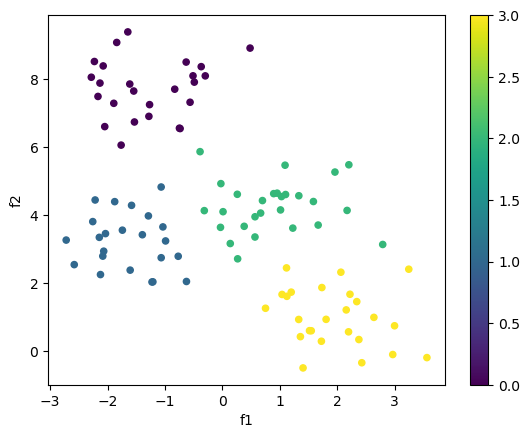

In [22]:
# The four clusters as they were predicted
df.plot(x="f1", y="f2", kind="scatter", c=pred_cluster, cmap="viridis")

<Axes: xlabel='f1', ylabel='f2'>

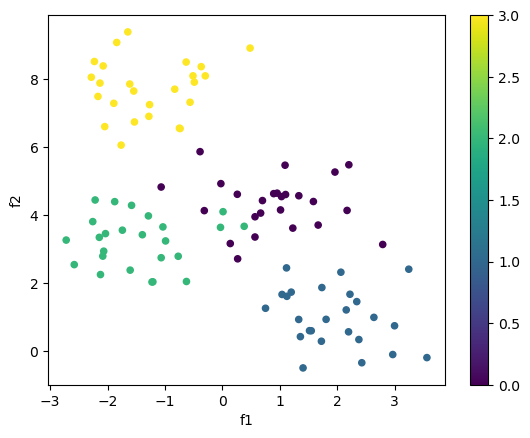

In [23]:
# The four clusters as they were originally generated
df.plot(x="f1", y="f2", kind="scatter", c=targets, cmap="viridis")

In [24]:
# The WCSS for sklearn is stored in model.inertia_ 
model.inertia_

116.3949170956415

In [25]:
# Calculate the wcss for models ranging between 1 and 10 clusters:
wcss_list = []

for K in range(1, 11):
    # Initialize the model
    model = KMeans(n_clusters=K)
    model.fit(features)
    wcss_list.append(model.inertia_)

print(wcss_list)

[920.4740308515607, 457.8838595904916, 203.19637718510026, 116.35753700635209, 100.92470731606929, 91.59226652219525, 83.51981324248413, 74.95873638552493, 64.14606788986625, 61.70338668718117]


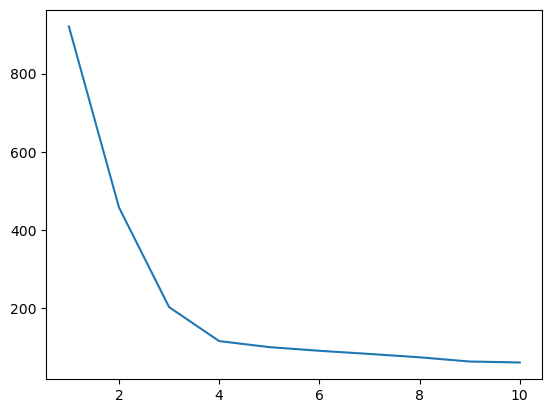

In [26]:
# Plot these wcss values

#        X-values      Y-values
plt.plot(range(1, 11), wcss_list)

In the graph above, the "elbow" is located at K=4. So the best number of clusters is 4.

## Actual dataset
The "seeds.csv" dataset contains 7 features of 210 seeds:

- area
- perimeter
- compactness
- length
- width
- asymmetry
- length.1

The goal is to predict how many different kinds of seeds there are in the dataset

**Note:** since we don't have anything to see if we are correct, there is no need to split into a training and test set. It could however still be interesting to try some normalization!

In [27]:
# Load the data
data = pd.read_csv("../data/seeds.csv")
data.head()

,area,perimeter,compactness,length,width,asymmetry,length.1
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [28]:
# Print the shape of the data
data.shape

(210, 7)

In [29]:
# Describe the data
data.describe()

,area,perimeter,compactness,length,width,asymmetry,length.1
count,210.000000,210.000000,207.000000,210.000000,209.000000,210.000000,210.000000
mean,14.847524,14.559286,0.871280,5.563918,3.281440,3.693530,5.407386
std,2.909699,1.305959,0.023306,0.719594,0.419907,1.495112,0.527212
min,10.590000,12.410000,0.808100,0.818900,2.630000,0.765100,3.485000
25%,12.270000,13.450000,0.857700,5.244750,2.956000,2.600250,5.045250
50%,14.355000,14.320000,0.873500,5.518000,3.245000,3.599000,5.247000
75%,17.305000,15.715000,0.887650,5.979750,3.566000,4.768750,5.878500
max,21.180000,17.250000,0.918300,6.675000,5.325000,8.456000,6.735000


In [30]:
# Are there na values?
np.any(data.isna())

True

In [31]:
# Display the na values
data[np.any(data.isna(), axis=1)]

,area,perimeter,compactness,length,width,asymmetry,length.1
35,16.12,15.0,NaN,0.9000,NaN,5.709,3.485
169,11.24,13.0,NaN,0.8359,5.090,2.715,3.521
170,11.02,13.0,NaN,0.8189,5.325,2.701,6.735


In [32]:
# Drop the na values:
data.dropna(inplace=True)

Text(0, 0.5, 'WCSS')

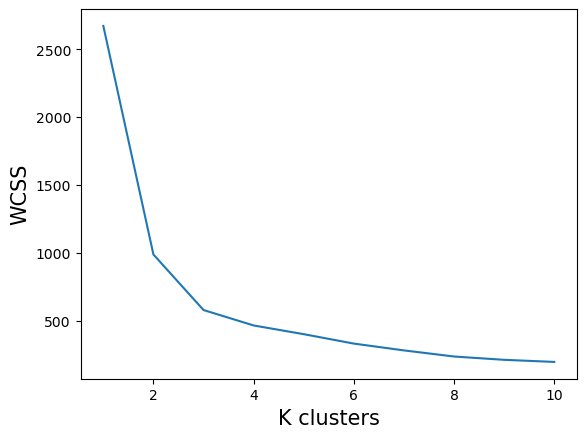

In [33]:
# Calculate the wcss for models ranging between 1 and 10 clusters:
wcss_list = []

for K in range(1, 11):
    model = KMeans(n_clusters=K)
    model.fit(data)
    wcss_list.append(model.inertia_)

plt.plot(range(1, 11), wcss_list)
plt.xlabel('K clusters', fontsize=15)
plt.ylabel('WCSS', fontsize=15)

Based on the plot above, the optimal number of clusters would be 3. So there are probably three different types of seeds in this dataset

In [34]:
# The 3 cluster model:
model = KMeans(n_clusters=3)
model.fit(data)

print("WCSS:", model.inertia_)

WCSS: 577.0914255401648


# Hierarchical clustering
K-means clustering is an example of partitional clustering. We divide the data into K groups.

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. 

When we build this hierarchy by combining points into clusters, and these in bigger clusters, we call this **Agglomerative hierarchical clustering**

If we build the hierarchy by splitting the dataset in increasingly smaller clusters, we call this **Divisive hierarchical clustering**

In the image below, you can view the difference:

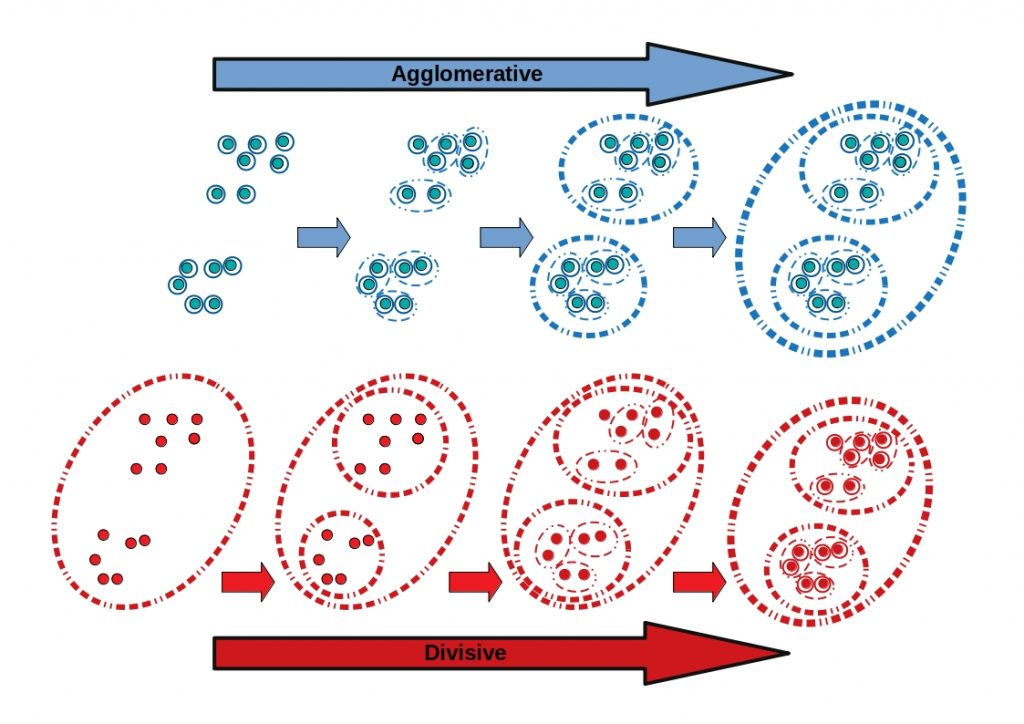

We can set the number of clusters by allowing only a limited amount of splits in our hierarchical tree.

A tree is also great for visualizing the structure of the data!
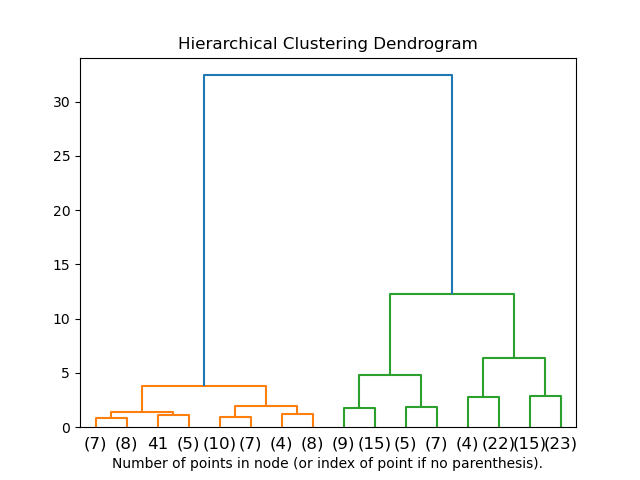

To create such a tree, the distance between different clusters needs to be calculated. There are multiple different strategies for this:
- Single linkage minimizes the distance between the closest observations of pairs of clusters.
    - L(r,s) = min(Distance($x_{ri},x_{sj}$))
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
    - L(r,s) = max(Distance($x_{ri},x_{sj}$))
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.
    - L(r,s) = $\frac{1}{n_rn_s}\sum_{i=1}^{n_r}\sum_{j=1}^{n_s}$Distance($x_{ri},x_{sj}$)
    - Less sensitive for outliers but has a preference for global clusters. It's also very computationally intensive!
- Ward or centroid linkage minimizes the sum of squared differences within all clusters. Very similar to K-means clustering but in a hierarchical way.

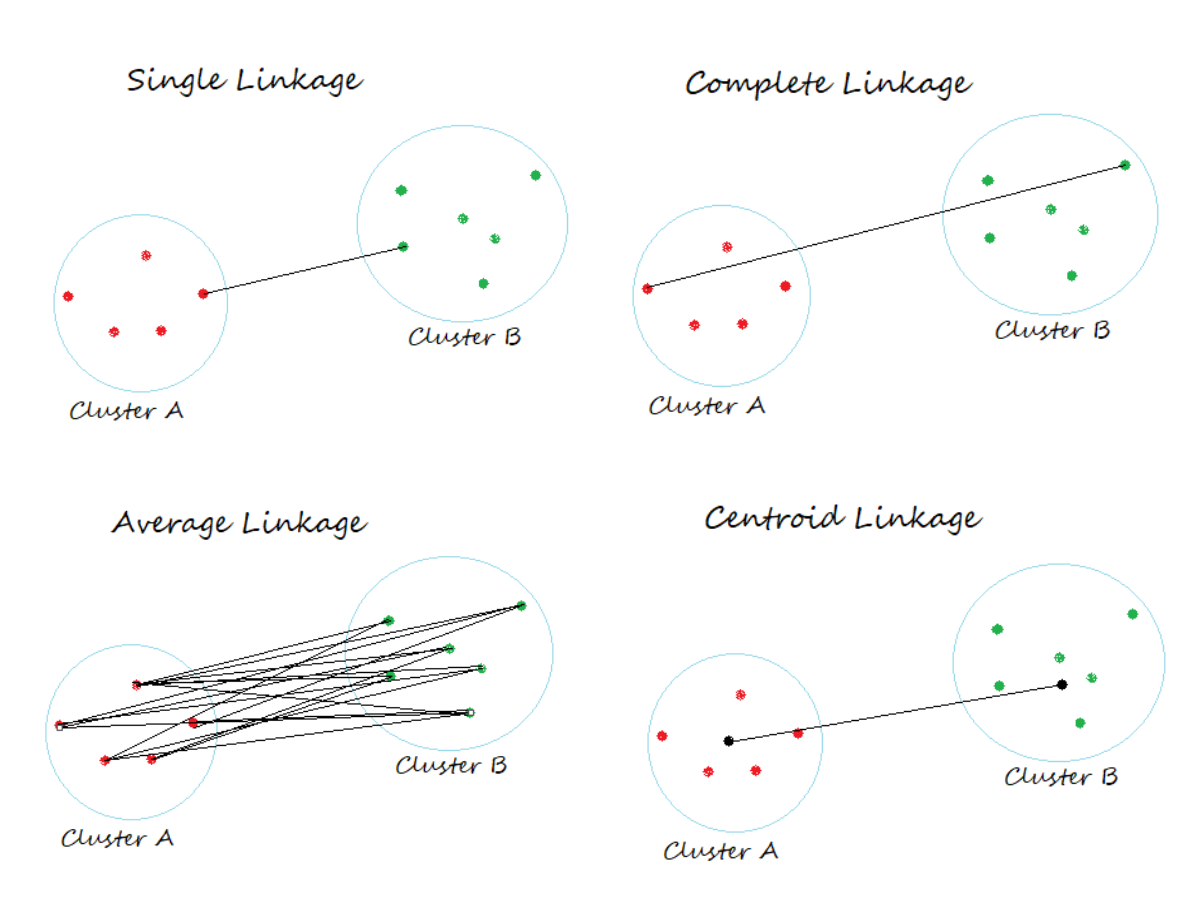

Hierarchical clustering in general is computationally intensive. The number of calculations is at least quadratically dependent on the total number of datapoints! => Not usable for large datasets.

In [35]:
# Import modules
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Create an Agglomerative Clustering model
# Linkage can be changed to any of ‘ward’, ‘complete’, ‘average’, ‘single’
model=AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage="average")

# Train/fit the model
model.fit(data)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

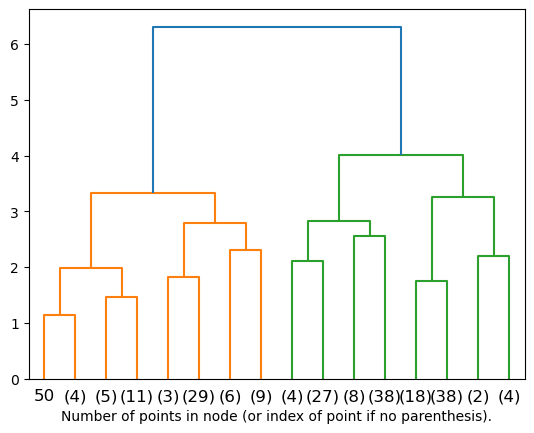

In [36]:
# We can plot this as a tree
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Dimensionality reduction
In our previous example, we had 7 features. However, we can only visualize up to 3 dimensions.

This is where dimensionality reduction comes in. We can reduce the number of features to a smaller set of 'principal' features.

Most used algorithms:
- Principal component analysis (PCA)
- Linear Discriminant Analysis (LDA)
- Multidimensional scaling (MDS)
- Uniform Manifold Approximation and Projection (UMAP)
- t-distributed stochastic neighbor embedding (t-SNE)
- Autoencoders (special neural network)
- Missing values Ratio
- Low variance filter

Applications of dimensionality reductions:
- Visualizations
- Removing noise
- Data compression
- 'The curse of dimensionality'
    - If the number of features get really big, it will be more difficult to train certain algorithms

## Principal component analysis (PCA)
PCA transforms a number of features to a smaller amount of non-correlated features, also called principal components, whilst preserving as much information as possible.

PCA will determine the eigenvectors of the data's covariance matrix that are scaled and shifted.

For a detailed explanation: https://setosa.io/ev/principal-component-analysis/

Imagine we have a dataset that looks as following:
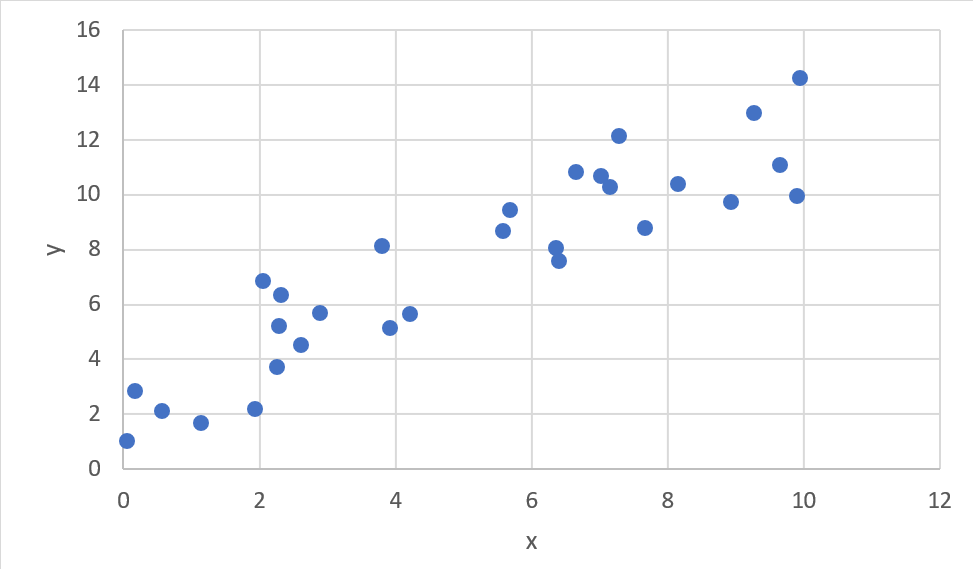

Determine the line that has the least distance to each point. (Different from linear regression. There it was the sum of least squares, meaning, the red lines below would go straight down instead of being perpendicular). This line is principal component 1. The line perpendicular to PC1 is PC2.

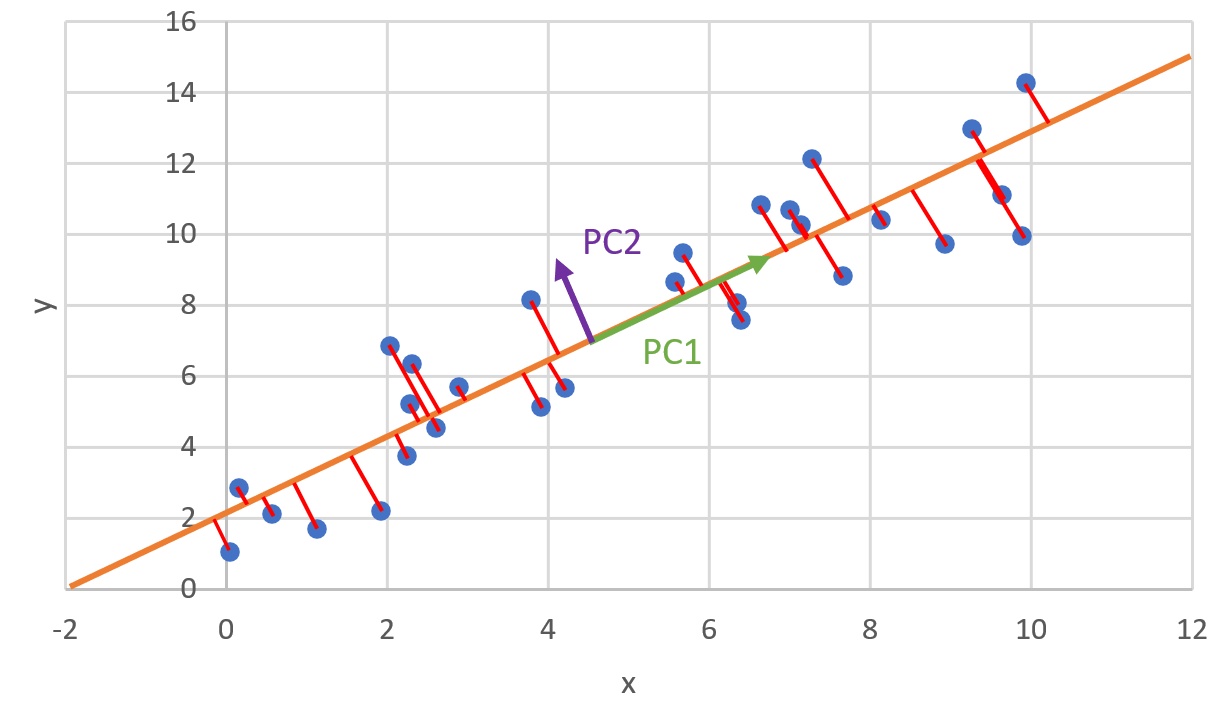

Rotate the data according to this line and center it around 0,0

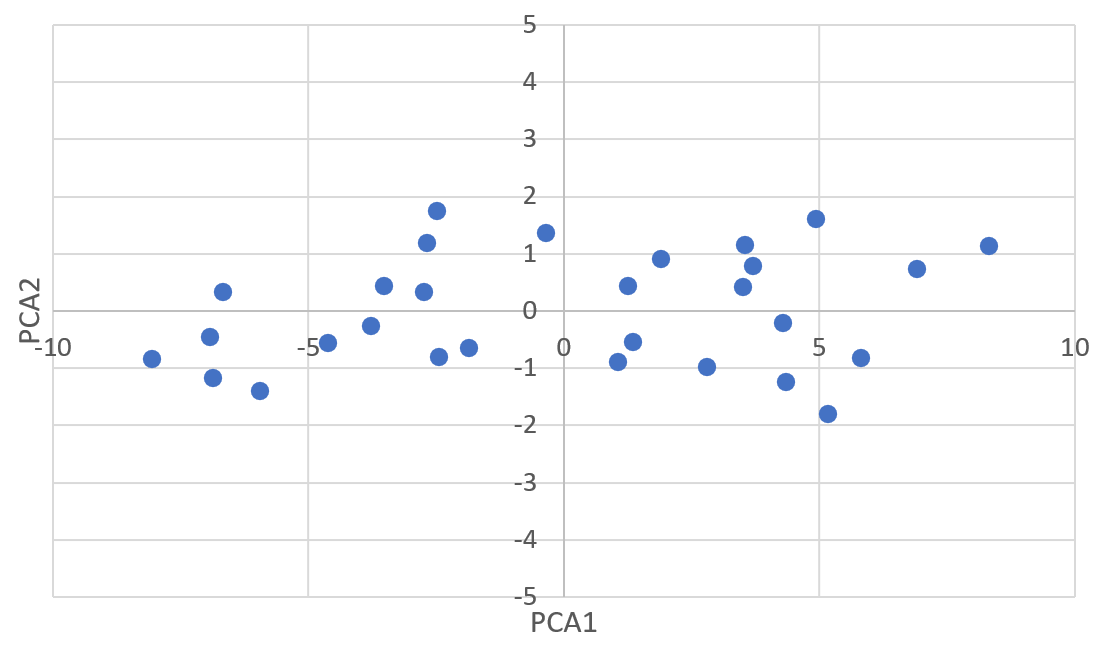

Thinking back about the seeds dataset, we had 7 features. We could not visualize this, but what if we would perform a PCA?

In [37]:
# Read in the data
data = pd.read_csv("../data/seeds.csv")
display(data.head())
data.dropna(inplace=True)

,area,perimeter,compactness,length,width,asymmetry,length.1
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


<Axes: xlabel='PC1', ylabel='PC2'>

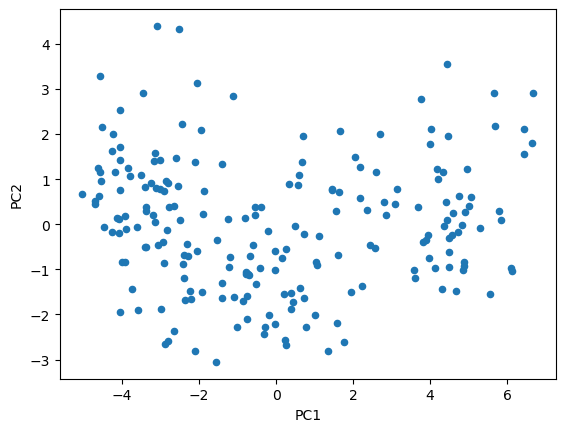

In [38]:
from sklearn.decomposition import PCA

# Create a PCA model with 2 components (instead of the 7 features of the dataset)
PCA_model = PCA(n_components=2)
PCA_data = PCA_model.fit_transform(data)
PCA_df = pd.DataFrame(data=PCA_data,columns=["PC1","PC2"])

# plot the PCA data
PCA_df.plot(x="PC1",y="PC2",kind="scatter")

Before, we saw that the optimal number of clusters was 3. This is also kind off visible in the PCA data.

We could use the PCA_model to also transform new data. Meaning that we can use the PCA output to train a model.
So let's now also create a K-means clustering model with the three clusters.

<Axes: xlabel='PC1', ylabel='PC2'>

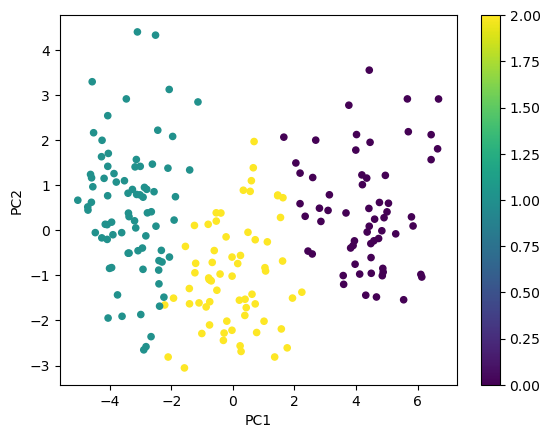

In [39]:
# Creat KMeans model with 3 clusters
model=KMeans(n_clusters=3)

# Fit the model
model.fit(PCA_df)
# Predict the clusters for each sample
pred_cluster = model.predict(PCA_df)
# The predicted clusters shown as a color
PCA_df.plot(x="PC1", y="PC2", kind="scatter", c=pred_cluster, cmap="viridis")

Other algorithms (not discussed):
- LDA: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
- MDS: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
- UMAP: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
    - Note: not included in sklearn.
    - Often used in Single-cell analysis
- t-SNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- Autoencoders
    - Short video explaining the idea of autoencoders: https://www.youtube.com/watch?v=Rdpbnd0pCiI
- Missing values ratio:
    - Look at the ratio of missing values within the features. Only keep the features that have a ratio lower than a certain treshold
- Low variance filter:
    - Take a look at the variance of a feature. Only keep features with a variance higher than a certain treshold

## MNIST
MNIST is interesting to look at since it has 784 features (the pixel values). This means that it will take a while for a normal model to fit the data. But now that we have dimensionality reduction, we can reduce the features and hopefully also reduce the time!

In [40]:
# Load data
MNIST = pd.read_csv("../data/MNIST.csv")
features=MNIST.drop("label",axis=1)
targets=MNIST.label

In [41]:
%%time 
#Will print the time it took to train the logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(n_jobs=-1,max_iter=100)
model.fit(features,targets)
model.score(features,targets)

/home/cedric/miniforge3/envs/bit07/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 1.46 s, sys: 2.38 s, total: 3.83 s
Wall time: 40.7 s


0.9380714285714286

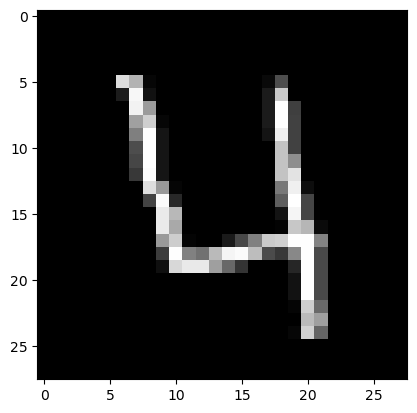

In [43]:
# Show the first image from MNIST
plt.imshow(features.values[3].reshape(28,28),cmap="gray")

In [44]:
# Reduce it to 10 Principal components
PCA_model = PCA(n_components=20)
PCA_features = PCA_model.fit_transform(features)
# Lets take a look at the values of the principal components of the first picture
print("784 pixels have been converted into 10 values:",PCA_features[0])


784 pixels have been converted into 10 values: [-661.59577877 -699.31133564  183.28204305  120.61143217  -81.08191566
  489.46161156 -683.47187134   85.55571525  348.54710869  203.00120956
 -364.56550488   21.25841314  404.45556957  -96.74995563   61.57366014
  -87.59432771   17.30392026  285.09646202   17.97260554  207.98894299]


In [45]:
%%time
model = LogisticRegression(n_jobs=-1,max_iter=100)
model.fit(PCA_features,targets)
model.score(PCA_features,targets)

CPU times: user 189 ms, sys: 149 ms, total: 337 ms
Wall time: 5.4 s


/home/cedric/miniforge3/envs/bit07/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8755238095238095

**Note 1:** of course we lose information and therefore our accuracy drops. But with just 10 values instead of 784, we can get the right digit in 80% of the cases!

**Note 2:** we used supervised learning here, not clustering. So this is why we can use the accuracy score here!

### Reconstruction of data via principal components
Principal components can be used to reconstruct the data as well!

We can visualize the components of the PCA because the PC is based on the initial data and basically describes how much each feature is used in this component. (For images: how much influence does each pixel have on the PC?)

So each component has 784 values. So we can also turn these into images.

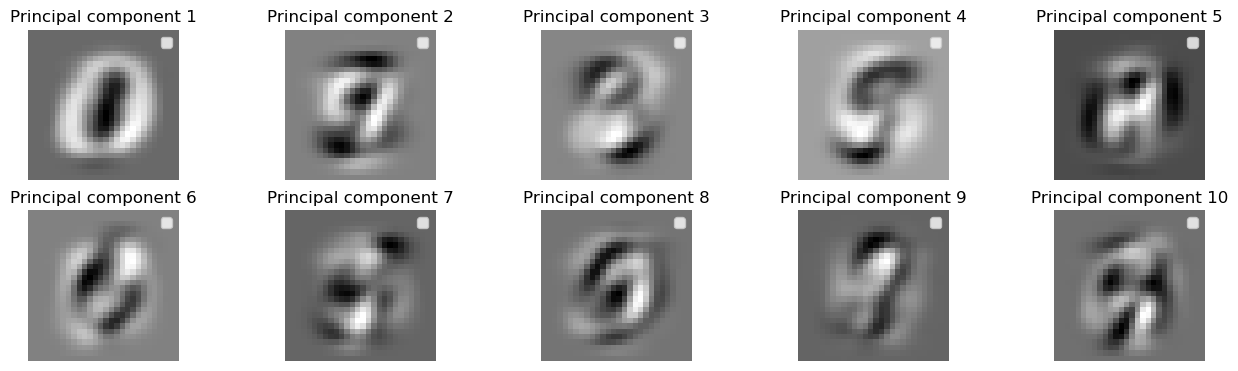

In [46]:
# Get the values for the principal components
PCA_components = PCA_model.components_

fig = plt.figure(figsize=(16, 9)) 
for i in range(0,10):
    ax = fig.add_subplot(4, 5, i+1)
    plt.imshow(PCA_components[i].reshape((28,28)),cmap='gray')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axis('off')
    plt.legend('off')
    
    ax.set_title('Principal component '+str(i+1))
    # x and y axis should be equal length
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
plt.show()

For each transformed datapoint, we basically get a 10 values describing how many times we should take the corresponding PC.

E.g., PCA_features = [-662, -699, 183, 121, -81, 489, -683, 85, 349, 202]

This basically means:
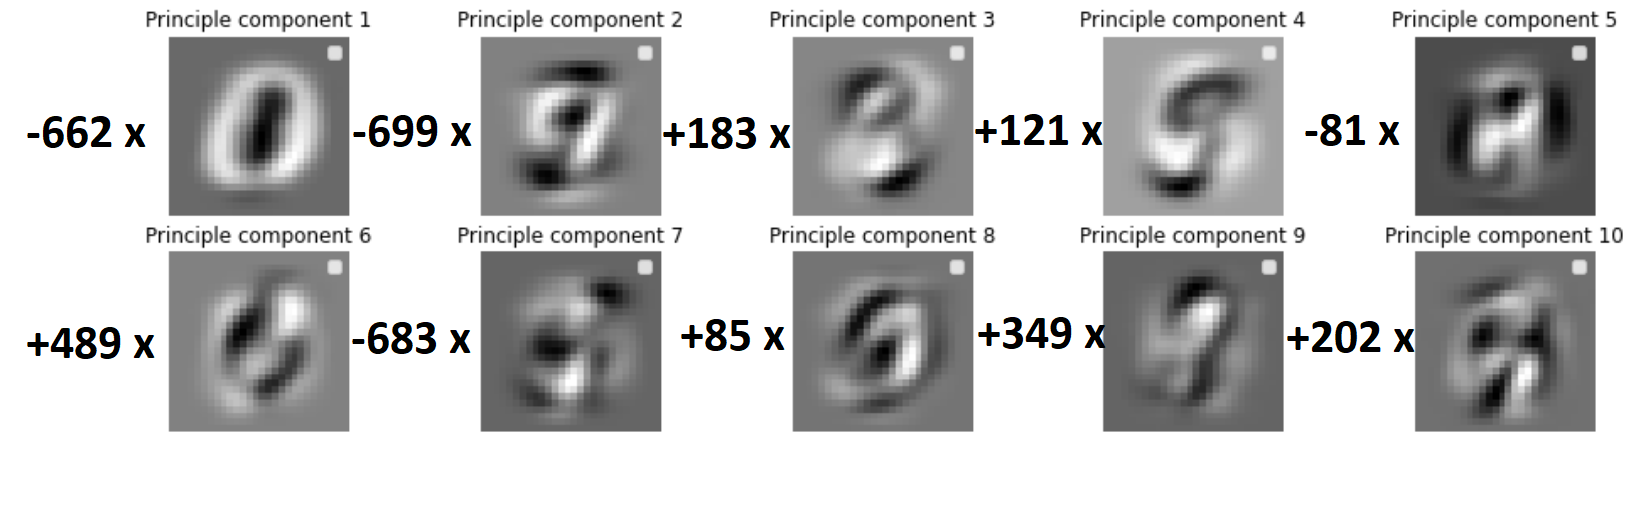

So we could reconstruct the data based on this information.

Conveniently for us, sklearn's PCA has a inverse_transform function!

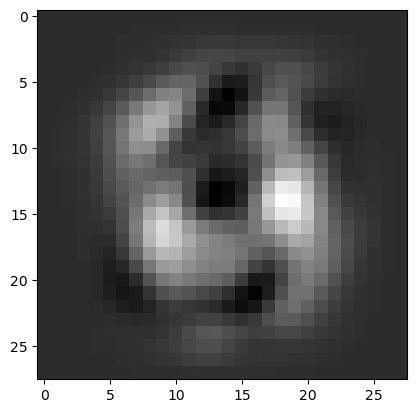

In [47]:
# Try and reconstruct the first image from the 10 PC
reconstructed = PCA_model.inverse_transform(PCA_features[3])
plt.imshow(reconstructed.reshape(28,28),cmap='gray')

### Determining a good number of principal components
To determine the best number of principal components, we can plot the explained variance by each component.

We can then base us on the this plot to determine a good cutoff that explains a good amount of the variability.

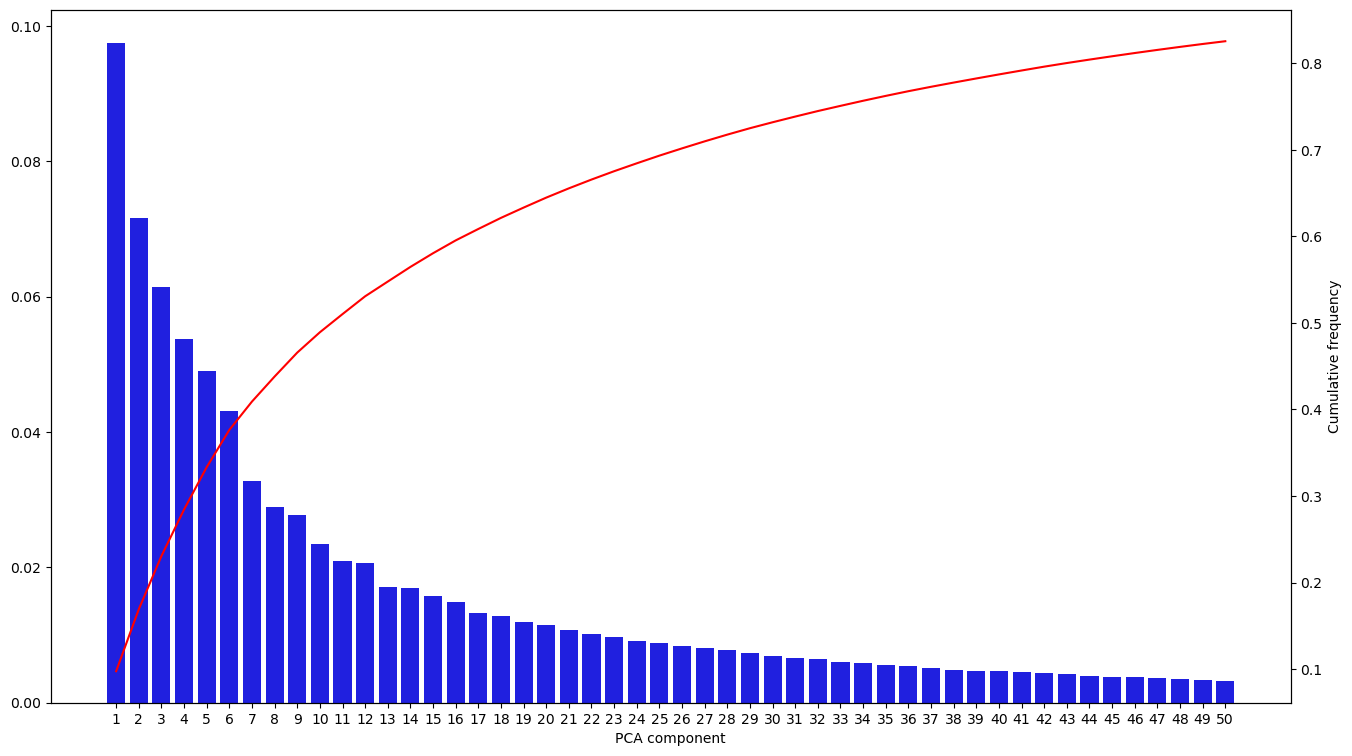

In [48]:
import seaborn as sns
PCA_model = PCA(n_components=50)
PCA_model.fit(features)

# The sum of the component + all previouse components
PCA_explained_cumulative = np.cumsum(PCA_model.explained_variance_ratio_)
fig = plt.figure(figsize=(16, 9)) 
ax=sns.barplot(x=list(range(1,PCA_model.n_components+1)),y=PCA_model.explained_variance_ratio_,color='blue')
plt.xlabel('PCA component')
ax2=ax.twinx() # double y-axis
ax.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Cumulative frequency')
plot=plt.plot(PCA_explained_cumulative, c='red')

